In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import os
%matplotlib inline

# Check if CUDA is available
use_cuda = True
if not os.environ.get("CUDA_VISIBLE_DEVICES"):
    use_cuda = False

if use_cuda:
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Set to the GPU device index you want to use
else:
    os.environ["CUDA_VISIBLE_DEVICES"] = ""  # Set to an empty string to use CPU

print(os.environ["CUDA_VISIBLE_DEVICES"])

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)
    
def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [80]:
create_pngs_from_wavs('audio/noisy_speech/SNR_-3dB', 'Spectrograms/noisy_speech/SNR_-3dB')

In [81]:
create_pngs_from_wavs('audio/noisy_speech/SNR_-6dB', 'Spectrograms/noisy_speech/SNR_-6dB')

In [82]:
create_pngs_from_wavs('audio/noisy_speech/SNR_-9dB', 'Spectrograms/noisy_speech/SNR_-9dB')

In [83]:
create_pngs_from_wavs('audio/test_speech', 'Spectrograms/speech')

In [84]:
from keras.utils import load_img, img_to_array

def load_images_from_path(path):
    images = []

    for file in os.listdir(path):
        images.append(img_to_array(load_img(os.path.join(path, file), target_size=(224, 224, 3))))
        
    return images

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)
        
x = []
y = []

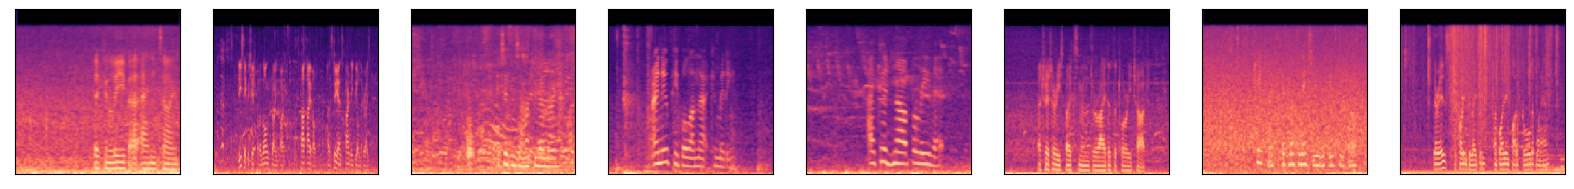

In [85]:
images = load_images_from_path('Spectrograms/noisy_speech/SNR_-3dB')
show_images(images)
    
x += images

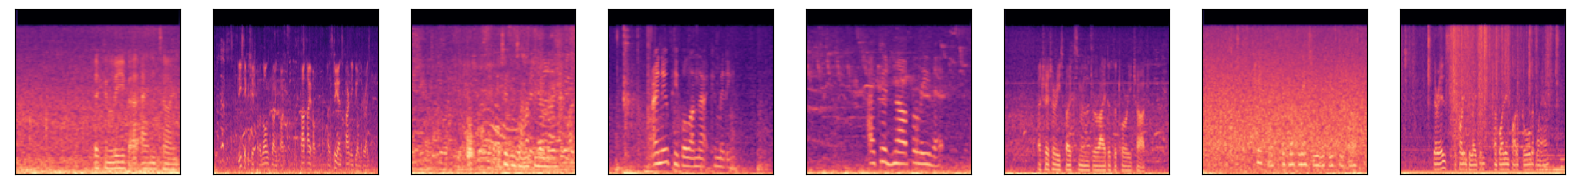

In [86]:
images = load_images_from_path('Spectrograms/noisy_speech/SNR_-6dB')
show_images(images)
    
x += images

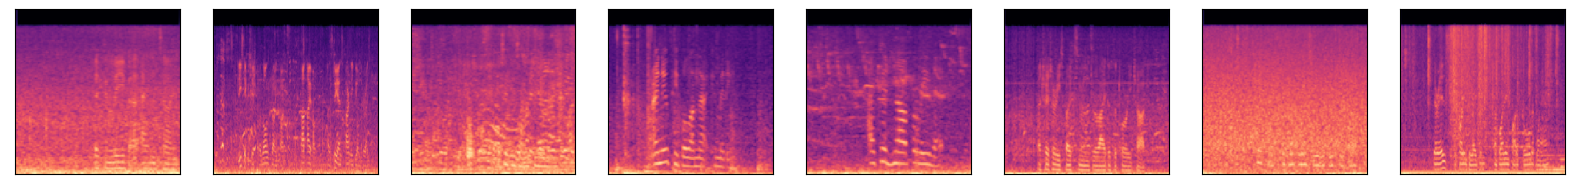

In [87]:
images = load_images_from_path('Spectrograms/noisy_speech/SNR_-9dB')
show_images(images)
    
x += images

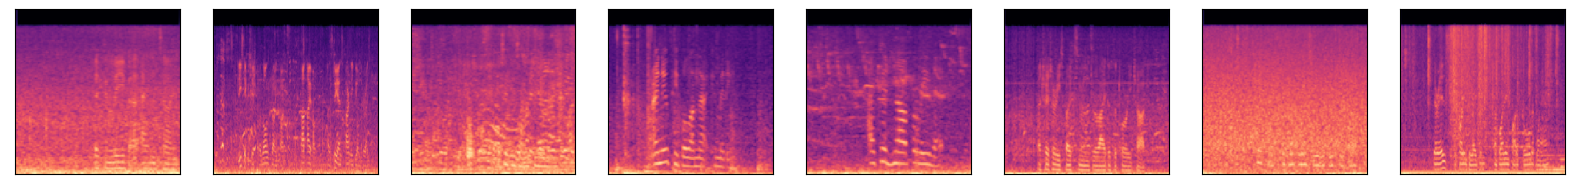

In [88]:
images = load_images_from_path('Spectrograms/noisy_speech/SNR_-9dB')
show_images(images)
    
y += images
y += images
y += images

In [89]:
print(len(y))

150


In [90]:
print(len(x))

150


In [151]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0) 

x_train_norm = np.array(x_train) / 255
x_test_norm = np.array(x_test) / 255

y_train_norm = np.array(y_train) / 255
y_test_norm = np.array(y_test) / 255

In [169]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense

# Build and compile the model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(2, 2))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(224 * 224 * 3, activation='sigmoid'))  # Output layer for regression

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_130 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_128 (MaxPooli  (None, 111, 111, 32)     0         
 ng2D)                                                           
                                                                 
 conv2d_131 (Conv2D)         (None, 109, 109, 128)     36992     
                                                                 
 max_pooling2d_129 (MaxPooli  (None, 54, 54, 128)      0         
 ng2D)                                                           
                                                                 
 conv2d_132 (Conv2D)         (None, 52, 52, 128)       147584    
                                                                 
 max_pooling2d_130 (MaxPooli  (None, 26, 26, 128)    

In [170]:
# Reshape target output
y_train_reshaped = np.reshape(y_train_norm, (y_train_norm.shape[0], 224 * 224 * 3))
y_test_reshaped = np.reshape(y_test_norm, (y_test_norm.shape[0], 224 * 224 * 3))

In [127]:
print(x_train_norm.shape)
print(x_test_norm.shape)

(120, 224, 224, 3)
(30, 224, 224, 3)


In [128]:
print(y_train_norm.shape)
print(y_test_norm.shape)

(120, 224, 224, 3)
(30, 224, 224, 3)


In [171]:
# Train the model
if use_cuda:
    # Use GPU
    import tensorflow as tf
    from keras.utils import multi_gpu_model

    model = multi_gpu_model(model, gpus=2)  # Modify the `gpus` parameter based on the number of GPUs available

    with tf.device("/gpu:0"):  # Modify the GPU device index ("/gpu:0") based on your system configuration
        hist = model.fit(x_train_norm, y_train_reshaped, validation_data=(x_test_norm, y_test_reshaped), batch_size=10, epochs=10)
else:
    # Use CPU
    hist = model.fit(x_train_norm, y_train_reshaped, validation_data=(x_test_norm, y_test_reshaped), batch_size=10, epochs=10)

# Reshape predicted output
y_pred_reshaped = np.reshape(model.predict(x_test_norm), (y_test_norm.shape[0], 224, 224, 3))

Epoch 1/10
12/12 [==============================] - 21s 2s/step - loss: 0.0460 - mse: 0.0460 - val_loss: 0.0194 - val_mse: 0.0194
Epoch 2/10
12/12 [==============================] - 18s 2s/step - loss: 0.0151 - mse: 0.0151 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 3/10
12/12 [==============================] - 17s 1s/step - loss: 0.0136 - mse: 0.0136 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 4/10
12/12 [==============================] - 17s 1s/step - loss: 0.0132 - mse: 0.0132 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 5/10
12/12 [==============================] - 18s 2s/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0138 - val_mse: 0.0138
Epoch 6/10
12/12 [==============================] - 18s 1s/step - loss: 0.0128 - mse: 0.0128 - val_loss: 0.0125 - val_mse: 0.0125
Epoch 7/10
12/12 [==============================] - 18s 2s/step - loss: 0.0096 - mse: 0.0096 - val_loss: 0.0083 - val_mse: 0.0083
Epoch 8/10
12/12 [==============================] - 18s 2s/step - loss: 0.0078 - mse: 0.00

In [172]:
# Check available keys in hist.history
print(hist.history.keys())

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


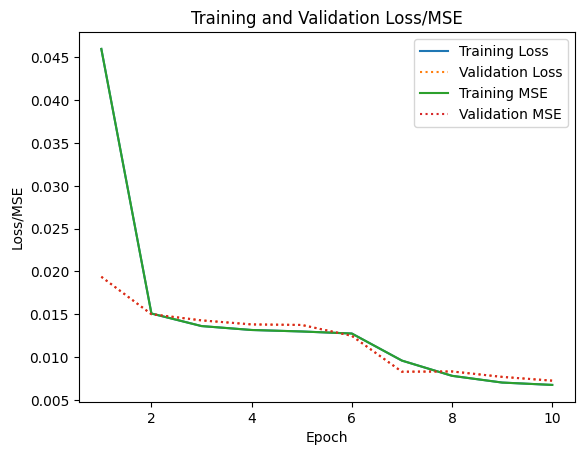

In [173]:
import matplotlib.pyplot as plt

# Modify the code based on the available metric names
loss = hist.history['loss']
val_loss = hist.history['val_loss']
mse = hist.history['mse']
val_mse = hist.history['val_mse']
epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, '-', label='Training Loss')
plt.plot(epochs, val_loss, ':', label='Validation Loss')
plt.plot(epochs, mse, '-', label='Training MSE')
plt.plot(epochs, val_mse, ':', label='Validation MSE')
plt.title('Training and Validation Loss/MSE')
plt.xlabel('Epoch')
plt.ylabel('Loss/MSE')
plt.legend(loc='upper right')
plt.show()

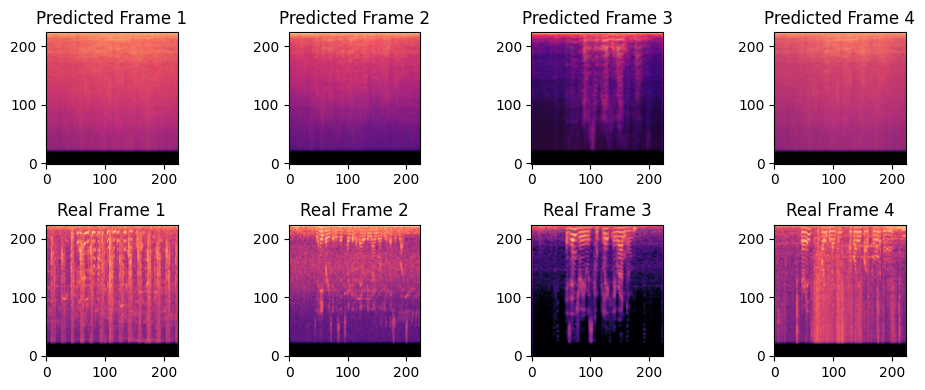

In [174]:
import matplotlib.pyplot as plt

# Assuming you have the predicted spectrogram stored in y_pred_reshaped and the real spectrogram in y_true

# Display a sample of the predicted spectrogram frames
plt.figure(figsize=(10, 4))
for i in range(4):  # Displaying 4 frames for illustration
    plt.subplot(2, 4, i+1)
    plt.imshow(y_pred_reshaped[i], cmap='jet', origin='lower')
    plt.title('Predicted Frame {}'.format(i+1))

# Display a sample of the real spectrogram frames
for i in range(4):  # Displaying 4 frames for illustration
    plt.subplot(2, 4, i+5)
    plt.imshow(y_test_norm[i], cmap='jet', origin='lower')
    plt.title('Real Frame {}'.format(i+1))

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()